In [17]:
import os
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
from scipy.ndimage import gaussian_filter1d
from scipy.signal import deconvolve
from scipy.signal import convolve
from scipy.special import gamma
from scipy.optimize import minimize
import pandas as pd

from scipy.integrate import quad

from scipy.integrate import simps

In [18]:
dcm_path = 'SRS00013/IMG00001.DCM'
folder_path = 'SRS00013/'  # Update this to the path of your DICOM folder

aif_pixel = (171,110,9)
# vof_pixel = (171,108,13)
# vof_pixel = (124,195,17)
# vof_pixel = (123, 200, 16)
vof_pixel = (197, 122, 17)
tissue_pixel = (150, 152, 13)

aif_pixels = [aif_pixel]
vof_pixels = [vof_pixel]

xyztuples = [  
    (*aif_pixel, True),
    (*vof_pixel, True),
    ]

TE = 32

#1.5T
# x1 = 0.044
x1 = 22.7
x2 = 7.6 * 10 ** (-3)
x3 = 574 * 10 ** (-6)
# #3T
# x1 = 11.5
# x2 = 0.493 * 10 ** (-3)
# x3 = 2.62 * 10 ** (-3)


# Define the hematocrit correction factor kH
Ha = 0.45  # Typical arterial hematocrit
Ht = 0.25  # Typical tissue hematocrit        
kH = (1 - Ha) / (1 - Ht)

# Initialize a list to hold your image data
image_data = []
acquisition_times = []
image_positions = []
acquisition_numbers =[]
instance_numbers = []

dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.DCM')]

Benchmark

RT: 1590
TE: 32
flip angle: 90

In [19]:
def time_to_seconds(t):
    """Converts a time string in HHMMSS.fff format to seconds."""
    hours, minutes, seconds = int(t[:2]), int(t[2:4]), float(t[4:])
    return 3600 * hours + 60 * minutes + seconds

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Preprocess the image as necessary. This is just a placeholder for any actual preprocessing you need to do.
    # For example: image = preprocess(ds.pixel_array)
    image_data.append(equalize_adapthist(gaussian(ds.pixel_array, sigma=1)))
    # image_data.append(ds.pixel_array)
    
    # Extract acquisition time; note that you'll need to adjust 'AcquisitionTime' based on your DICOM files' metadata structure
    acquisition_times.append(time_to_seconds(ds.AcquisitionTime))
    image_positions.append(ds.ImagePositionPatient)
    acquisition_numbers.append(ds.AcquisitionNumber)
    instance_numbers.append(ds.InstanceNumber)
    
image_data = np.array(image_data)
image_positions = np.array(image_positions)
acquisition_times = np.array(acquisition_times)

# Assuming these are your original lists:
# image_data = [np.array(...) for _ in range(1000)]  # Each a 256x256 numpy array
# image_position = [np.array(...) for _ in range(1000)]  # Each a 1x3 numpy array
# acquisition_time = [np.random.rand() for _ in range(1000)]  # Each a random float

# Step 1: Combine the lists into a single list of tuples
combined = list(zip(image_data, image_positions, acquisition_times, acquisition_numbers, instance_numbers))

# combined.sort(key=lambda x: x[-1])

combined.sort(key=lambda x: x[2])
# Step 2: Sort the combined list by the image_position (assuming it's the second element of the tuple)
combined.sort(key=lambda x: x[1][1])  # Adjust the lambda function if sorting criteria are different

# Step 3: Separate the combined list back into three lists
image_data_sorted, image_position_sorted, acquisition_time_sorted, acquisition_numbers_sorted, instance_numbers_sorted = zip(*combined)

# If you need the results to be in list format instead of tuples (especially for the image data), you can convert them
# image_data_sorted = list(equalize_adapthist(gaussian(np.array(image_data_sorted) , sigma=1)))
image_data_sorted = list(image_data_sorted)
image_position_sorted = list(image_position_sorted)
acquisition_time_sorted = list(acquisition_time_sorted)
acquisition_numbers_sorted = list(acquisition_numbers_sorted)
instance_numbers_sorted = list(instance_numbers_sorted)

image_data_sorted = np.array(image_data_sorted)

def intensity_to_concentration(intensity, LV, TE=TE, x1=x1, x2=x2, x3=x3):
    s0 = np.mean(intensity[3:12])  # Baseline signal intensity
    st = intensity  # Signal intensity at different times after contrast injection
    # Calculating contrast agent concentration using the provided formula
    delR2star = -(1/TE) * np.log(st/s0)
    
    if LV:
        # Use only one calculation, directly applying conditions to determine the correct formula
        c = np.where(delR2star >= 0,
                     (-x2 + np.sqrt(x2**2 + 4 * x3 * delR2star)) / (2 * x3),
                     (x2 - np.sqrt(x2**2 + 4 * x3 * delR2star)) / (2 * x3))
    else:
        c = x1 * delR2star
    return c

def plt_point(x,y,z,view=False, LV=True):
    times = acquisition_time_sorted[50*(z-1):50*z]-min(acquisition_time_sorted)
    concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y], LV)
    if view:
        print("InstanceNumbers: ")
        print(instance_numbers_sorted[50*(z-1):50*z])
        print("AcquisitionNumbers: ")
        print(acquisition_numbers_sorted[50*(z-1):50*z])
        print("unique image_positions: ")
        print(np.unique(image_position_sorted[50*(z-1):50*z]))
    
    # Assuming 'concentration' and 'time_points' are your data arrays
    plt.figure(figsize=(10, 6))
    plt.plot(times, concentrations, '-o', label='Concentration over Time')
    plt.title(f'Concentration vs. Time at <{x},{y},{z}>*\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Interactive visualization of 3D data over time
def explore_3dimage_time(i=0,z=0,x=0,y=0,vis=False,aif=False):
    if vis:
        i = (z-1)*50+i
        plt.figure(figsize=(10, 5),facecolor='k')
        plt.imshow(image_data_sorted[i, :, :], cmap='gray')  # Adjust the 15 here to show different slices
        plt.title(f'#: {instance_numbers_sorted[i]} Position: {image_position_sorted[i]} \n T#: {acquisition_numbers_sorted[i]} Time: {acquisition_time_sorted[i]}',color='blue')
        plt.axis('off')
        plt.scatter(x, y, color='red', s=10)  # Highlight the point
        plt.tight_layout()
        plt.show()
    if aif: 
        plt_point(x,y,z)
        
def smooth_data_gaussian(data, sigma=1):
    """
    Smooths the data using a Gaussian filter.

    :param data: The input data to smooth.
    :param sigma: The standard deviation for the Gaussian kernel.
    :return: The smoothed data.
    """
    return gaussian_filter1d(data, sigma)

def plt_pointss(xyztuples=None, view=False, smooth=False, legend_on=False):
    if xyztuples is None:
        xyztuples = [(0, 0, 0, False)]
    plt.figure(figsize=(5, 6))
    
    for i, (x, y, z, LV) in enumerate(xyztuples):
        times = np.array(acquisition_time_sorted[50*(z-1):50*z]) - np.min(acquisition_time_sorted)
        concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y], LV)
        
        # Smooth the concentration data using Gaussian filter
        if smooth:
            smoothed_concentrations = smooth_data_gaussian(concentrations)
        else:
            smoothed_concentrations = concentrations.copy()

        if view:
            print(f"Data for {x},{y},{z}")
            print("InstanceNumbers: ")
            print(instance_numbers_sorted[50*(z-1):50*z])
            print("AcquisitionNumbers: ")
            print(acquisition_numbers_sorted[50*(z-1):50*z])
            print("unique image_positions: ")
            print(np.unique(image_position_sorted[50*(z-1):50*z]))
            print(times)
            print(acquisition_time_sorted[50*(z-1):50*z])
            print()  # Print a newline for readability
        
        plt.plot(times, smoothed_concentrations, '-o', label=f'<{x},{y},{z}>')
    
    plt.title('Smoothed Concentration vs. Time for Multiple Points\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    if legend_on:    
        plt.legend()
    plt.grid(True)
    plt.show()

Figure 1.

In [20]:
# Function to draw the slices with points
def draw_slices_with_points(i=0):
    fig, axes = plt.subplots(4, 5, figsize=(10, 8), facecolor='black') # Adjust the subplot grid if needed
    axes = axes.flatten()
    
    for z in range(1, 21): # Assuming you have 20 slices
        ax = axes[z-1]
        img_index = (z-1) * 50 + i # Calculate the index of the image to show
        ax.imshow(image_data_sorted[img_index, :, :], cmap='gray')
        
        # Draw the specified points for the current slice
        for x, y, slice_z in aif_pixels:
            if slice_z == z: # Check if the point belongs to the current slice
                ax.scatter(x, y, color='red', s=10)
        for x, y, slice_z in vof_pixels:
            if slice_z == z: # Check if the point belongs to the current slice
                ax.scatter(x, y, color='blue', s=10)
        
        # ax.set_title(f'Slice #{z}')
        ax.axis('off')
    
    plt.tight_layout()
    # plt.savefig('AIF_Tissue_Points.png', facecolor='black', transparent=True)
    plt.show()
    
# Create a slider to interact with the function
interact(draw_slices_with_points, i=IntSlider(min=0, max=49, step=1, value=20))

interactive(children=(IntSlider(value=20, description='i', max=49), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_slices_with_points(i=0)>

Figure 2pre

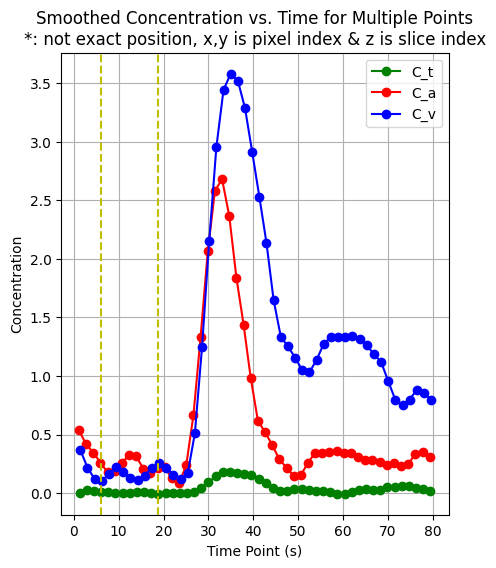

In [21]:
def read_point4time(x,y,z):
    """Read time points for a given slice."""
    return acquisition_time_sorted[50*(z-1):50*z] - min(acquisition_time_sorted)

def read_point4concentration(x, y, z, LV):
    """Read concentration data for a given point."""
    return intensity_to_concentration(image_data_sorted[50*(z-1):50*z, x, y], LV)  

def get_time_concentration_array(x, y, z, LV):
    """Combine time and concentration data into a single two-dimensional array."""
    time_data = read_point4time(x, y, z)
    concentration_data = read_point4concentration(x, y, z, LV)
    
    # Combine into a single array where each row is [time, concentration]
    combined_array = np.column_stack((time_data, concentration_data))
    
    return combined_array

C_t = get_time_concentration_array(*tissue_pixel, LV=False)
C_a = get_time_concentration_array(*aif_pixel, LV=True)
C_v = get_time_concentration_array(*vof_pixel, LV=True)

def figure2(C_t, C_a, C_v, smooth=False, legend_on=False):
    plt.figure(figsize=(5, 6))
    baseline_s = []
    baseline_e = []
    for i, C in enumerate((C_t, C_a, C_v)):
        if i == 0: name, color = "C_t", "green"
        elif i == 1: name, color = "C_a", "red"
        else: name, color = "C_v", "blue"
        times = C[:, 0]
        concentrations = C[:, 1]
        # Smooth the concentration data using Gaussian filter
        if smooth:
            smoothed_concentrations = smooth_data_gaussian(concentrations)
        else:
            smoothed_concentrations = concentrations.copy()
        plt.plot(times, smoothed_concentrations, '-o', label=f'{name}', color=color)
        baseline_s.append(times[3])
        baseline_e.append(times[11])
    plt.title('Smoothed Concentration vs. Time for Multiple Points\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    if legend_on:    
        plt.legend()
    plt.axvline(x=np.mean(baseline_s), color='y', linestyle='--', label='Baseline Start')
    plt.axvline(x=np.mean(baseline_e), color='y', linestyle='--', label='Baseline End')
    plt.grid(True)
    plt.show()
    
figure2(C_t, C_a, C_v, smooth=True, legend_on=True)

InstanceNumbers: 
['17', '37', '57', '77', '97', '117', '137', '157', '177', '197', '217', '237', '257', '277', '297', '317', '337', '357', '377', '397', '417', '437', '457', '477', '497', '517', '537', '557', '577', '597', '617', '637', '657', '677', '697', '717', '737', '757', '777', '797', '817', '837', '857', '877', '897', '917', '937', '957', '977', '997']
AcquisitionNumbers: 
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']
unique image_positions: 
[-123.77108479 -120.01595721   80.55225643]


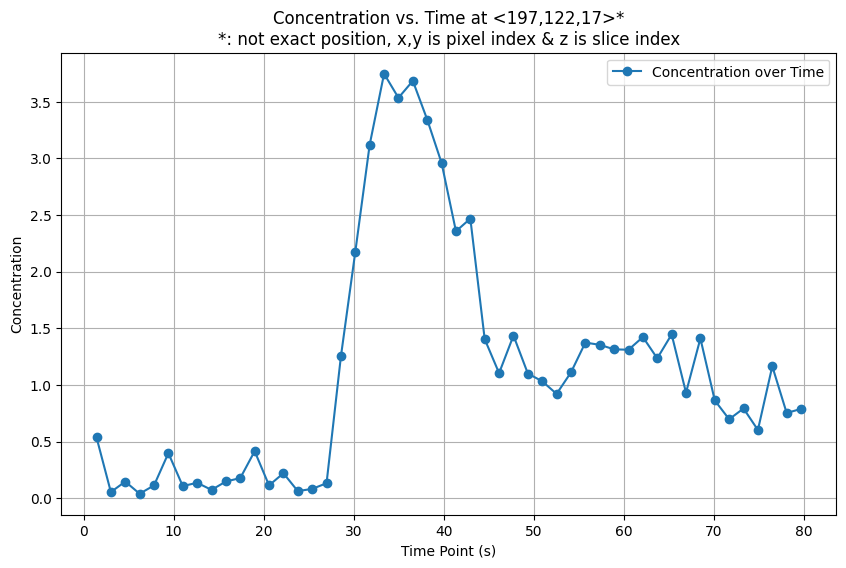

In [22]:
plt_point(*vof_pixel, True)

In [23]:
# Extract the time and concentration data
time_v = C_v[:, 0]
conc_v = C_v[:, 1]

time_a = C_a[:, 0]
conc_a = C_a[:, 1]

# Now, perform the trapezoidal integration over the time range
# Note: Ensure your time data is in seconds if it's not already, adjust accordingly
integral_cv = np.trapz(conc_v, time_v)
integral_ca = np.trapz(conc_a, time_a)

print("Integral of C_t (tissue) over time:", integral_cv)
print("Integral of C_a (arterial input function) over time:", integral_ca)

# Calculate kappa as the ratio of arterial to venous integrals
kappa = integral_ca / integral_cv

print("Computed kappa value:", kappa)

Integral of C_t (tissue) over time: 90.1547000228019
Integral of C_a (arterial input function) over time: 43.688884761703775
Computed kappa value: 0.48459908080947517


[(171, 110, 9, True), (197, 122, 17, True), (150, 152, 13, False)]
Data for 171,110,9
InstanceNumbers: 
['9', '29', '49', '69', '89', '109', '129', '149', '169', '189', '209', '229', '249', '269', '289', '309', '329', '349', '369', '389', '409', '429', '449', '469', '489', '509', '529', '549', '569', '589', '609', '629', '649', '669', '689', '709', '729', '749', '769', '789', '809', '829', '849', '869', '889', '909', '929', '949', '969', '989']
AcquisitionNumbers: 
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']
unique image_positions: 
[-133.29913649 -123.77108479   30.27744152]
[ 1.1175  2.7125  4.31    5.905   7.5025  9.1    10.695  12.2925 13.8875
 15.485  17.08   18.6775 20.2725 21.87   23.4675 25.0625 26.66   28.255
 29.8525 31.4475 33.045 

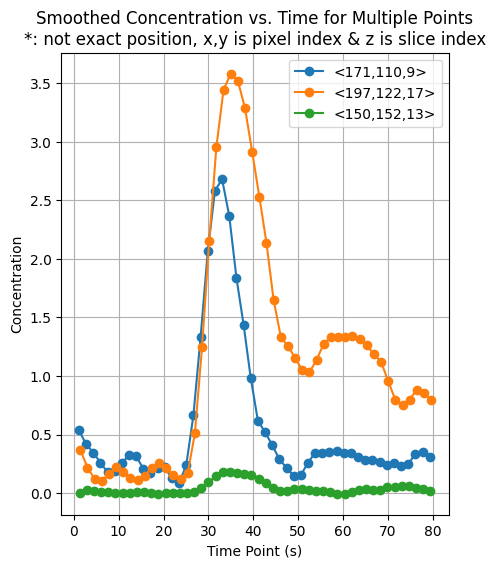

In [24]:
xyztuples.append((*tissue_pixel,False))
print(xyztuples)
plt_pointss(xyztuples,smooth=True, legend_on=True, view=True)